In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from gplearn.genetic import SymbolicRegressor
import graphviz
from sklearn.metrics import r2_score, mean_absolute_error

In [135]:
data = pd.read_csv("births.csv")
data.head()

,Date,Births
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44


In [136]:
data.set_index('Date', inplace = True)
data.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [137]:
TARGET_KEY = 'Births'

In [138]:
data.index = pd.to_datetime(data.index)

теперь мы можем делать срезы по периодам

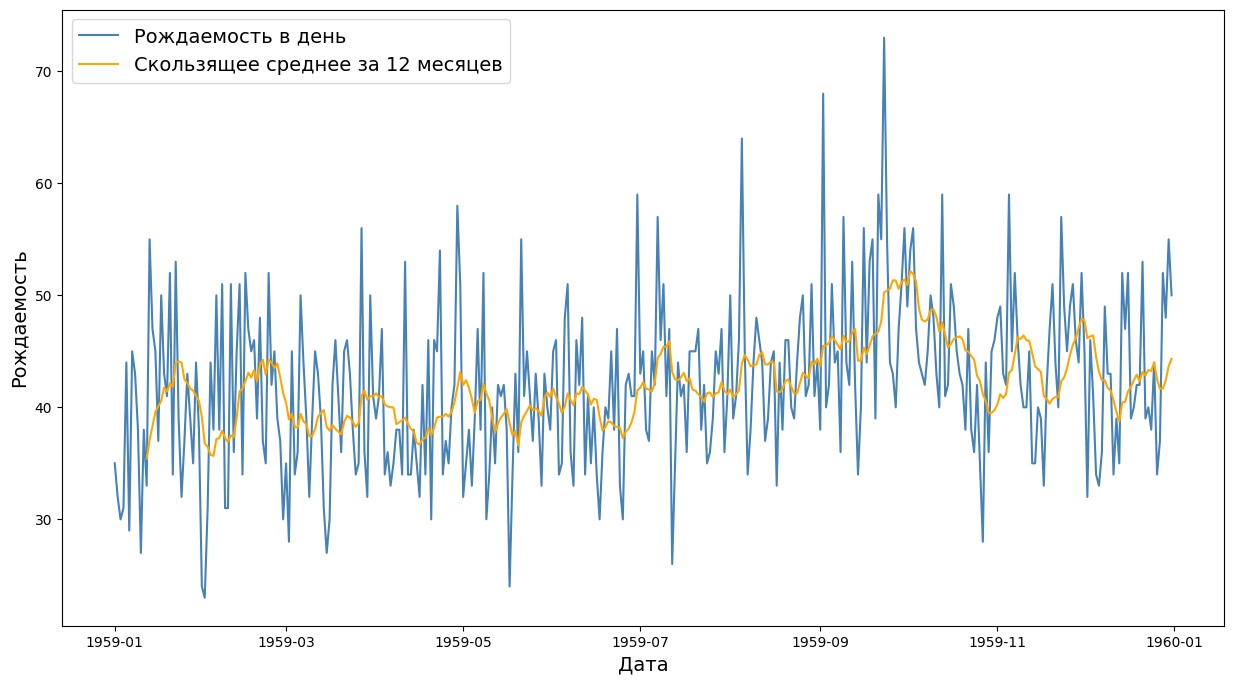

In [139]:
plt.figure(figsize = (15,8))

plt.plot(data, label = 'Рождаемость в день', color = 'steelblue')
plt.plot(data.rolling(window = 12).mean(), label = 'Скользящее среднее за 12 месяцев', color = 'orange')

plt.legend(title = '', loc = 'upper left', fontsize = 14)

plt.xlabel('Дата', fontsize = 14)
plt.ylabel('Рождаемость', fontsize = 14)

plt.show()

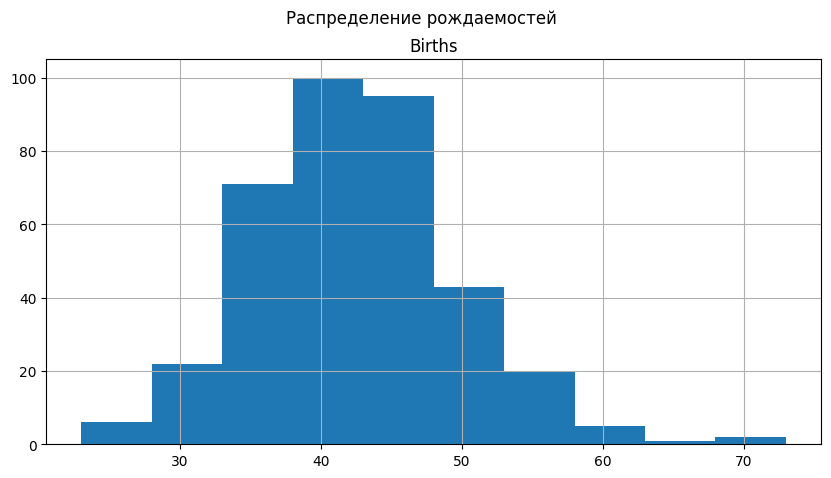

In [140]:
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Распределение рождаемостей')
data.hist(ax=ax, legend=False)
plt.show()

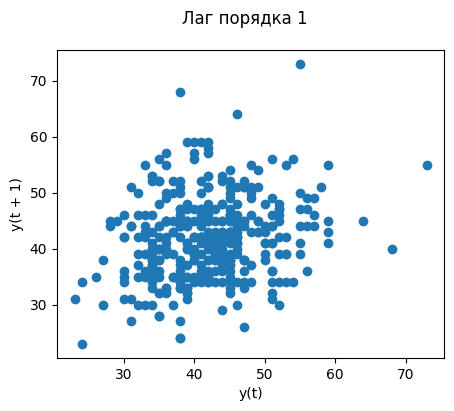

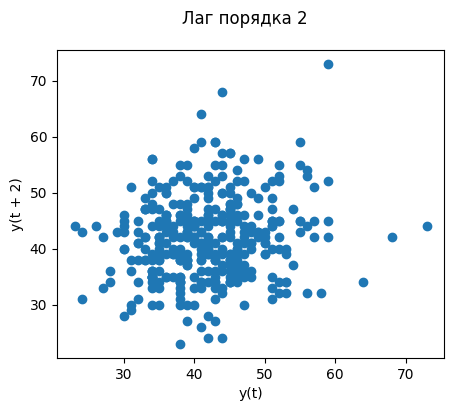

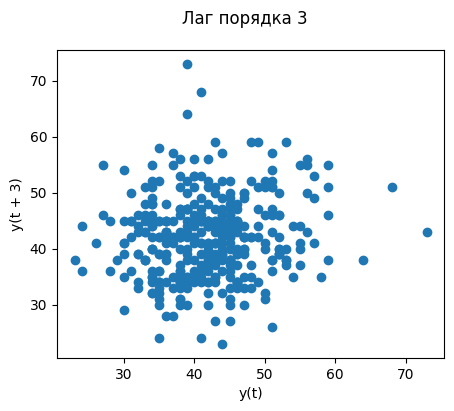

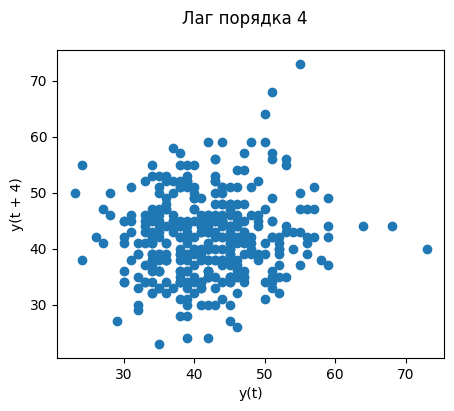

In [141]:
for i in range(1, 5):
    fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(5,4))
    fig.suptitle(f'Лаг порядка {i}')
    pd.plotting.lag_plot(data, lag=i, ax=ax)
    plt.show()

автокорреляция, в целом, не наблюдается

In [142]:
def plot_decompose(data=data[TARGET_KEY], model='add'):
    result_add = seasonal_decompose(data, model=model)
    fig = result_add.plot()
    fig.set_size_inches((10, 8))
    # Перерисовка
    fig.tight_layout()
    plt.show()

разделим на тенденции, цикличность и случайные колебания

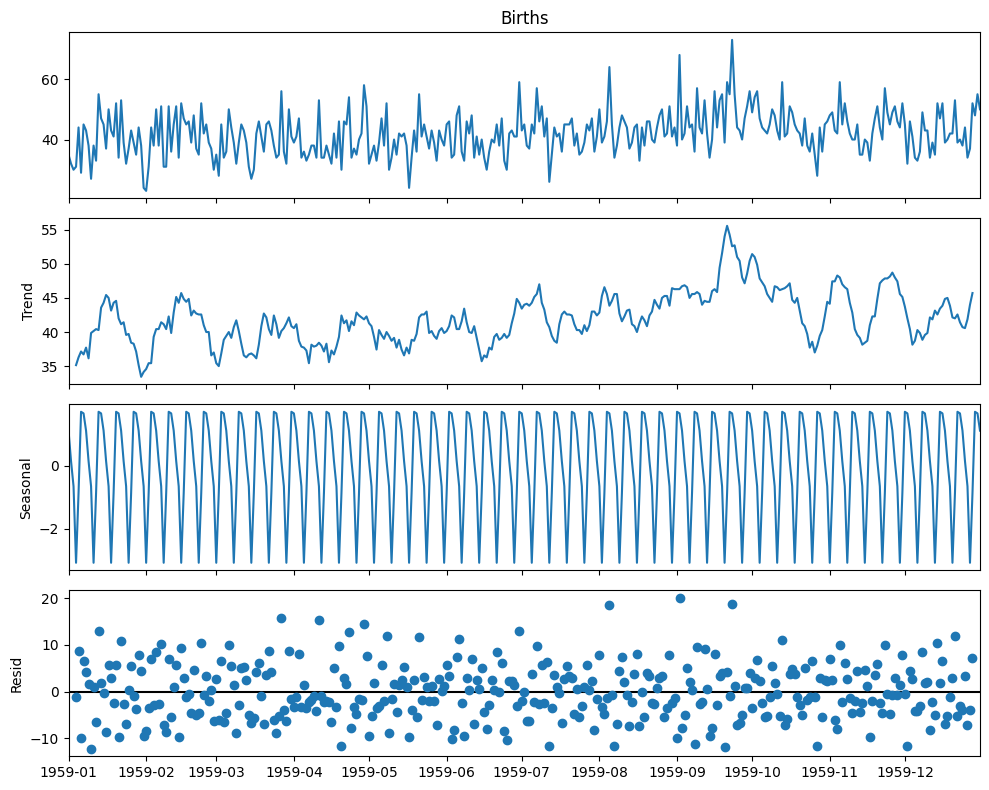

In [143]:
plot_decompose(data=data[TARGET_KEY], model='add')

# Прогнозирование временного ряда авторегрессионными методами

In [144]:
X = list(range(data.shape[0]))

y = data[TARGET_KEY].values
train_size = int(len(y) * 0.7)
X_train, X_test = X[0:train_size], X[train_size:]
y_train, y_test = y[0:train_size], y[train_size:]
history_arima = [x for x in y_train]
history_es = [x for x in y_train]

In [145]:
arima_order = (6,1,0)

arima_pred = list()
for i in range(len(y_test)):
    model_arima = ARIMA(history_arima, order=arima_order)
    model_arima = model_arima.fit()
    yhat_arima = model_arima.forecast()[0]
    arima_pred.append(yhat_arima)
    history_arima.append(y_test[i])

arima_mse = mean_squared_error(y_test, arima_pred, squared=False)

In [146]:
# Формирование предсказаний
hwes_pred = list()
for i in range(len(y_test)):
    model_es = ExponentialSmoothing(history_es)
    model_es = model_es.fit()
    yhat_es = model_es.forecast()[0]
    hwes_pred.append(yhat_es)
    history_es.append(y_test[i])
# Вычисление метрики RMSE
hwes_mse = mean_squared_error(y_test, hwes_pred, squared=False)

In [147]:
# Ошибка прогноза
np.mean(y), arima_mse, hwes_mse

(41.98082191780822, 7.082306298069498, 7.217016713264046)

In [148]:
# Записываем предсказания в DataFrame
data['predictions_ARIMA'] = (train_size * [np.NAN]) + list(arima_pred)
data['predictions_HWES'] = (train_size * [np.NAN]) + list(hwes_pred)

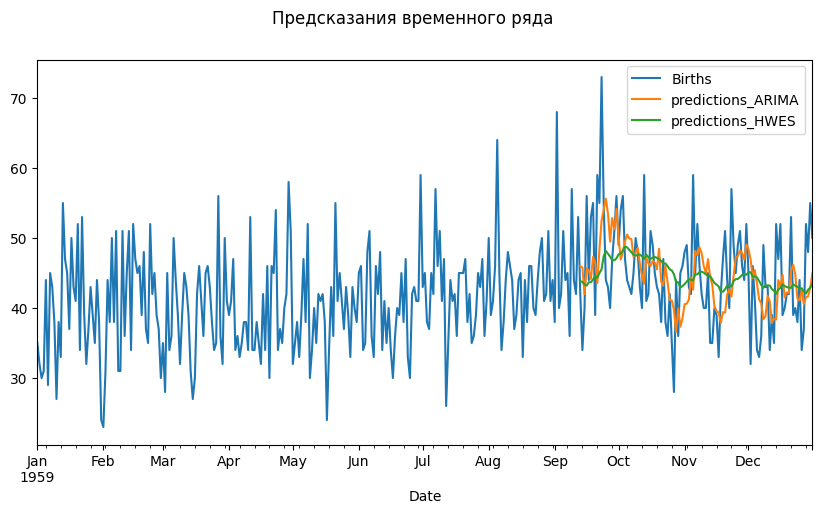

In [149]:
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда')
data.plot(ax=ax, legend=True)
plt.show()

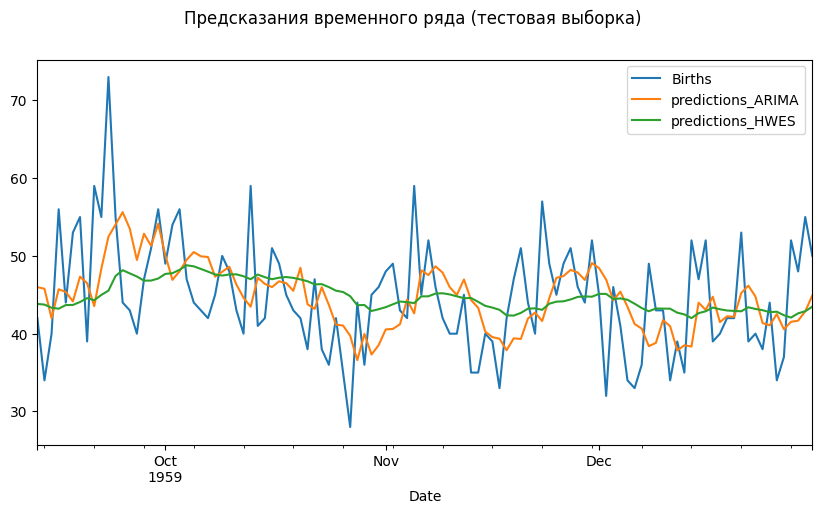

In [150]:
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда (тестовая выборка)')
data[train_size:].plot(ax=ax, legend=True)
plt.show()

# Прогнозирование временного ряда методом символьной регресии

In [151]:
function_set = ['add', 'sub', 'mul', 'div', 'sin']
gp = SymbolicRegressor(population_size=500, metric='mse',
                               generations=70, stopping_criteria=0.01,
                               init_depth=(4, 10), verbose=1, function_set=function_set,
                               const_range=(-100, 100), random_state=0)

In [152]:
gp.fit(np.array(X_train).reshape(-1, 1), y_train.reshape(-1, 1))

/home/pahan/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0   263.65      7.24858e+55       26           368.24              N/A     49.06s
   1   168.46      3.08763e+11      190          137.664              N/A     19.60s
   2   187.15      1.23463e+10      190           137.64              N/A     20.43s
   3   126.66      3.36087e+22       14          63.3652              N/A     15.94s
   4   178.60      6.78824e+13       14          63.3685              N/A     19.89s
   5   123.38      1.01443e+14       10          58.1649              N/A     15.36s
   6    16.83        3.043e+14       25          57.1643              N/A      7.22s
   7    13.11      4.06308e+14        9          50.0916              N/A      7.10s
   8    15.99      4.05734e+14       22          50.0506              N/A  

SymbolicRegressor(const_range=(-100, 100),
                  function_set=['add', 'sub', 'mul', 'div', 'sin'],
                  generations=70, init_depth=(4, 10), metric='mse',
                  population_size=500, random_state=0, stopping_criteria=0.01,
                  verbose=1)

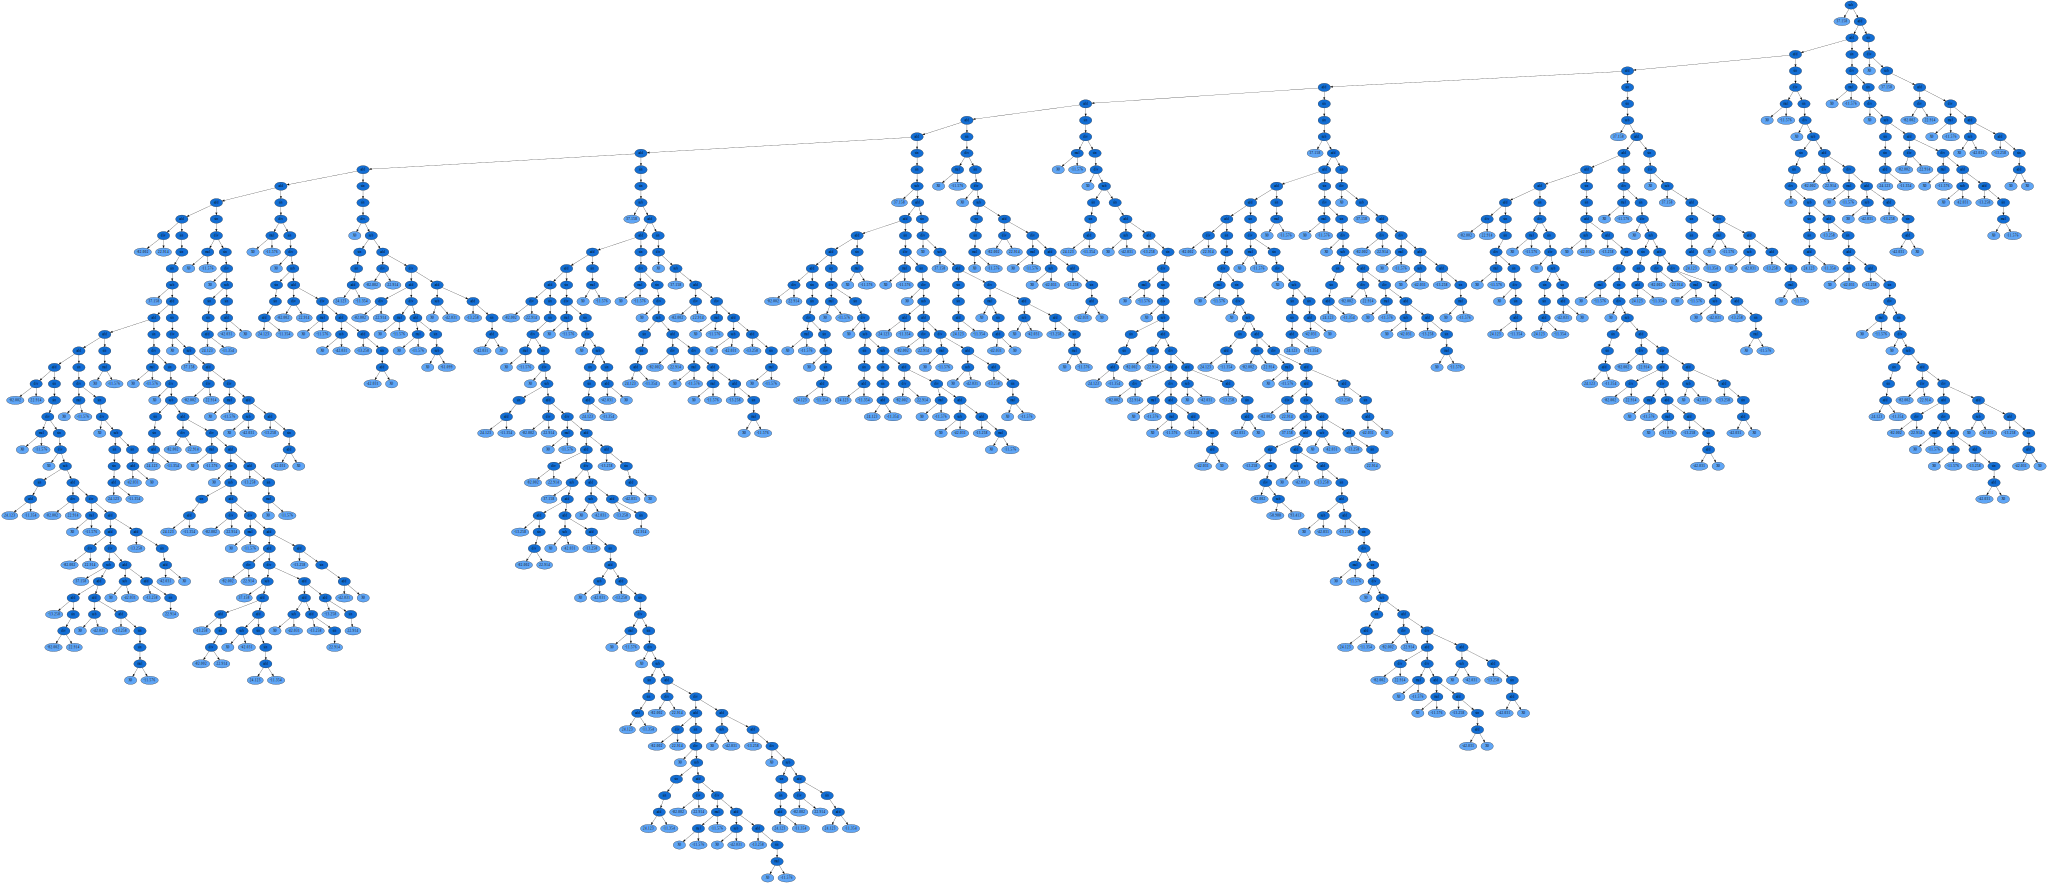

In [153]:
dot_data = gp._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph

In [154]:
gp_pred = gp.predict(np.array(X_test).reshape(-1, 1))
gp_pred[:10]

array([40.28938386, 36.55290694, 44.0910671 , 42.43899561, 47.00219962,
       45.03593076, 39.69664985, 46.57498875, 44.92532119, 43.89997191])

In [155]:
data['predictions_GPLEARN'] = (train_size * [np.NAN]) + list(gp_pred)

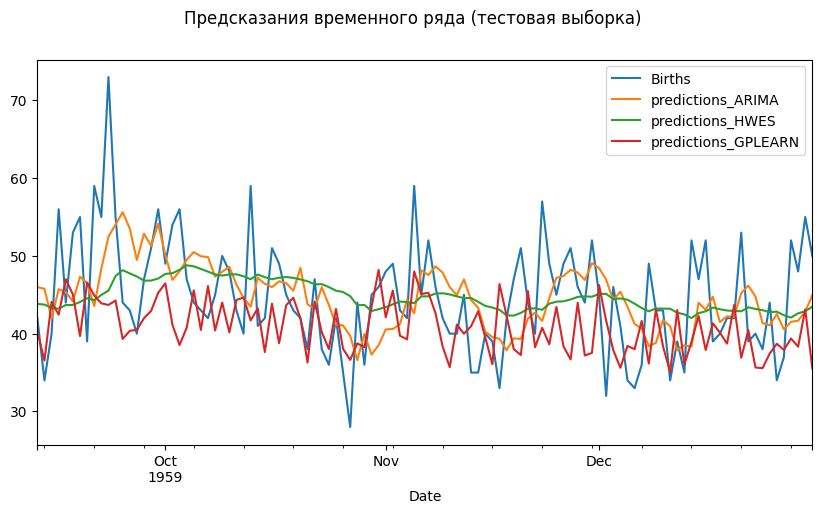

In [156]:
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда (тестовая выборка)')
data[train_size:].plot(ax=ax, legend=True)
plt.show()

In [157]:
data.head()

,Births,predictions_ARIMA,predictions_HWES,predictions_GPLEARN
Date,,,,
1959-01-01,35,NaN,NaN,NaN
1959-01-02,32,NaN,NaN,NaN
1959-01-03,30,NaN,NaN,NaN
1959-01-04,31,NaN,NaN,NaN
1959-01-05,44,NaN,NaN,NaN


In [158]:
r2_arima = r2_score(data[TARGET_KEY][train_size:], data['predictions_ARIMA'][train_size:])
r2_hwes = r2_score(data[TARGET_KEY][train_size:], data['predictions_HWES'][train_size:])
r2_gplearn = r2_score(data[TARGET_KEY][train_size:], data['predictions_GPLEARN'][train_size:])
mae_arima = mean_absolute_error(data[TARGET_KEY][train_size:], data['predictions_ARIMA'][train_size:])
mae_hwes = mean_absolute_error(data[TARGET_KEY][train_size:], data['predictions_HWES'][train_size:])
mae_gplearn = mean_absolute_error(data[TARGET_KEY][train_size:], data['predictions_GPLEARN'][train_size:])

In [159]:
pd.DataFrame.from_dict({
    'r2': {
        'arima': f'{round(r2_arima * 100, 3)}%',
        'hwes': f'{round(r2_hwes * 100, 3)}%',
        'gplearn': f'{round(r2_gplearn * 100, 3)}%'
    },
    'mae': {
        'arima': mae_arima,
        'hwes': mae_hwes,
        'gplearn': mae_gplearn
    }
})

,r2,mae
arima,3.383%,5.782839
hwes,-0.327%,5.723733
gplearn,-23.695%,6.118808
